# 使用`torchaudio`的音频分类

> 原文：<https://pytorch.org/tutorials/intermediate/speech_command_recognition_with_torchaudio.html>

本教程将向您展示如何正确设置音频数据集的格式，然后在数据集上训练/测试音频分类器网络。

首先，让我们导入常见的 Torch 包，例如[`torchaudio`](https://github.com/pytorch/audio)，可以按照网站上的说明进行安装。


In [22]:
import numpy as np
import random
import math
import time
import librosa
import pandas
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio.transforms as T
import torch.optim as optim
import torchaudio

import IPython.display as ipd
from tqdm.notebook import tqdm

让我们检查一下 CUDA GPU 是否可用，然后选择我们的设备。 在 GPU 上运行网络将大大减少训练/测试时间。

In [23]:
# 解决jupyter 频繁挂掉服务#15错误
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
torch.cuda.empty_cache() # 清除gpu缓存

In [24]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]='0,1,2,3'

In [25]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(torch.__version__, torchaudio.__version__, torch.cuda.is_available(),device)

1.11.0 0.11.0 True cuda


In [26]:
tensor = torch.randn(3,4,5)
tensor.type(),tensor.size(),tensor.dim()

('torch.FloatTensor', torch.Size([3, 4, 5]), 3)

In [27]:
seed=612
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)

In [28]:
torchaudio.list_audio_backends()

['soundfile', 'sox_io']

## 导入数据集

实际的加载和格式化步骤是在访问数据点时发生的，`torchaudio`负责将音频文件转换为张量。 如果想直接加载音频文件，可以使用`torchaudio.load()`。 

回到数据集，这里我们创建一个子类，将其分为标准训练，验证和测试子集。

In [29]:
import os
from pathlib import Path
from typing import Tuple, Optional, Union
import torchaudio
from torch import Tensor
from torch.utils.data import Dataset
import pandas as pd
import seaborn as sns

FOLDER_IN_ARCHIVE = "TAL-SER"
EXCEPT_FOLDER = "_background_noise_"
LABEL_FOLDER = 'label'
EXTENDED_DATASET_FOLDER='EXTENDED'

def pd_read_label(path:str):
    label_df = pd.read_csv(os.path.join(path,LABEL_FOLDER,'label'),sep=" ")
    utt2gen_df = pd.read_csv(os.path.join(path,LABEL_FOLDER,'utt2gen'),sep=" ",header=None,names=['id','sex'])

    label_P_dict=label_df.set_index('id')['P'].to_dict()
    label_A_dict=label_df.set_index('id')['A'].to_dict()
    sex_dict=utt2gen_df.set_index('id')['sex'].to_dict()
    return label_A_dict,label_P_dict,sex_dict

def _load_list(root, *filenames):
    output = []
    for filename in filenames:
        filepath = os.path.join(root, filename)
        with open(filepath) as fileobj:
            output += [os.path.normpath(os.path.join(root, line.strip())) for line in fileobj]
    return output

def get_labels(P, A):
    if  P>0:
        if A>0:return '积极高唤醒'
        else:return '消极高唤醒'
    else:
        if A<0:return '积极低唤醒'
        else:return '消极低唤醒'
        
def split_talser_dataset_tolist(path:str):
    talser_path='/mnt/pci-0000:00:1f.2-ata-1-part1/ZLQ/AI/data/TAL-SER/'
    label_df = pd.read_csv(talser_path+"label/label",sep=" ")
    utt2gen_df = pd.read_csv(talser_path+"label/utt2gen",sep=" ",header=None,names=['id','sex'])
    utt2spk_df = pd.read_csv(talser_path+"label/utt2spk",sep=" ",header=None,names=['id','speaker'])
    wavscp_df = pd.read_csv(talser_path+"label/wavscp",sep=" ",header=None,names=['id','path'])
    wavscp_df.sort_values('id', ignore_index=True,inplace =True)
    data_df = pd.concat([label_df, utt2spk_df['speaker'], utt2gen_df['sex'],wavscp_df['path']], axis=1)
    # data_df["path"].replace(".\/S", talser_path+"S", regex=True,inplace =True)
    del label_df
    del utt2gen_df
    del utt2spk_df
    del wavscp_df

    def function(P, A):
        if  P>0:
            if A>0:
                return 'AH'
            else:
                return 'PH'
        else:
            if A<0:
                return 'AL'
            else:
                return 'PL'
    data_df['emotion'] = data_df.apply(lambda x: function(x.P, x.A), axis = 1)
    
    from sklearn.model_selection import train_test_split
    train_df,test = train_test_split(data_df, test_size=0.4, random_state=0,
                                   stratify=data_df[['emotion']])
    val_df,test_df = train_test_split(test, test_size=0.5, random_state=0,
                                   stratify=test[['emotion']])
    train_df['path'].to_csv(os.path.join(path,'talser_train_list.txt'),sep=' ',index=0,header=0)
    val_df['path'].to_csv(os.path.join(path,'talser_validation_list.txt'),sep=' ',index=0,header=0)
    test_df['path'].to_csv(os.path.join(path,'talser_testing_list.txt'),sep=' ',index=0,header=0)
    
        
class TALSER(Dataset):
    def __init__(
        self,
        root: Union[str, Path],
        folder_in_archive: str = FOLDER_IN_ARCHIVE,
        subset: Optional[str] = None,
    ) -> None:

        assert subset is None or subset in ["training", "validation", "testing"], (
            "When `subset` not None, it must take a value from " + "{'training', 'validation', 'testing'}."
        )
        

        # Get string representation of 'root' in case Path object is passed
        root = os.fspath(root)
        self._path = os.path.join(root, folder_in_archive)
        self.label_A_dict, self.label_P_dict, self.sex_dict=pd_read_label(self._path)
        split_talser_dataset_tolist(self._path)
        
        if subset =='extended':
            self._walker = _load_list(self._path, EXTENDED_DATASET_FOLDER)
        if subset == "validation":
            self._walker = _load_list(self._path, "talser_validation_list.txt")
        elif subset == "testing":
            self._walker = _load_list(self._path, "tal_ser_testing_list.txt")
        elif subset == "training":
            excludes = set(_load_list(self._path, "talser_validation_list.txt", "talser_testing_list.txt"))
            walker = sorted(str(p) for p in Path(self._path).glob("*/*.wav"))
            self._walker = [
                w
                for w in walker
                if EXCEPT_FOLDER not in w and os.path.normpath(w) not in excludes
            ]
        else:
            walker = sorted(str(p) for p in Path(self._path).glob("*/*.wav"))
            self._walker = [w for w in walker if EXCEPT_FOLDER not in w]

    def __getitem__(self, n: int) -> Tuple[Tensor, int, str, int, int,str,str,int]:
        """Load the n-th sample from the dataset.

        Args:
            n (int): The index of the sample to be loaded
        Returns:
            (Tensor, int, str, str, int):
        """
        filepath = self._walker[n]
        relpath = os.path.relpath(filepath, self._path)
        speaker_id, filename = os.path.split(relpath)
        utterance_number,_= os.path.splitext(filename)# 分离文件名和拓展名
        utterance_number = int(utterance_number)
        P=self.label_P_dict[utterance_number]
        A=self.label_A_dict[utterance_number]
        sex=self.sex_dict[utterance_number]
        utterance_number = int(utterance_number)
        labels=get_labels(P,A)
        # Load audio
    
        waveform, sample_rate = torchaudio.load(filepath)
        return waveform, sample_rate, labels, P, A, sex, speaker_id, utterance_number

    
    def __len__(self) -> int:
        return len(self._walker)


In [50]:
import os

class SubsetSC(TALSER):
    def __init__(self, subset: str = None):
        super().__init__('/mnt/pci-0000:00:1f.2-ata-1-part1/ZLQ/AI/data/')

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.join(self._path, line.strip()) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("talser_validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("talser_testing_list.txt")
        elif subset == "training":
            self._walker = load_list("talser_train_list.txt")+load_list("talser_validation_list.txt")
#             excludes = load_list("talser_validation_list.txt") + load_list("talser_testing_list.txt")
#             excludes = set(excludes)
#             self._walker = [w for w in self._walker if w not in excludes]
            
# Create training and testing split of the data. We do not use validation in this tutorial.
train_set = SubsetSC("training")
test_set = SubsetSC("testing")
val_set=SubsetSC("validation")
waveform, sample_rate, labels, P, A, sex, speaker_id, utterance_number = train_set[0]

In [49]:
train_set[0],train_set.__len__(),test_set.__len__(),val_set.__len__(),(train_set.__len__()+test_set.__len__()+val_set.__len__())

((tensor([[ 0.0467,  0.5343,  0.7824,  ..., -0.0682,  0.0869,  0.1695]]),
  16000,
  '消极低唤醒',
  -1.342194963,
  0.539038381,
  'male',
  'SER005',
  5471),
 3350,
 838,
 838,
 5026)

Shape of waveform: torch.Size([1, 160000])
Sample rate of waveform: 16000


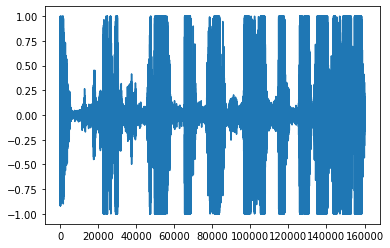

In [51]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))


plt.figure()
plt.plot(waveform.t().numpy())


让我们找到数据集中可用的标签列表。

In [33]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
labels

['消极低唤醒', '消极高唤醒', '积极低唤醒', '积极高唤醒']

In [34]:
waveform_first, *_ = train_set[0]
ipd.Audio(waveform_first.numpy(), rate=sample_rate)

In [35]:
waveform_second, *_ = train_set[1]
ipd.Audio(waveform_second.numpy(), rate=sample_rate)

In [36]:
waveform_last, *_ = train_set[-1]
ipd.Audio(waveform_last.numpy(), rate=sample_rate)


## 格式化数据

这是将转换应用于数据的好地方。 对于波形，我们对音频进行下采样以进行更快的处理，而不会损失太多的分类能力。

我们无需在此应用其他转换。 对于某些数据集，通常必须通过沿通道维度取平均值或仅保留其中一个通道来减少通道数量（例如，从立体声到单声道）。 由于`talser`使用单个通道进行音频，因此此处不需要。
其他变换 https://www.kaggle.com/code/elsash/i-o-torchaudio

In [37]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)

ipd.Audio(transformed.numpy(), rate=new_sample_rate)

Shape of spectrogram: torch.Size([1, 201, 801])


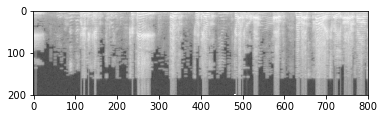

In [48]:
specgram = torchaudio.transforms.Spectrogram()(waveform)

print("Shape of spectrogram: {}".format(specgram.size()))

plt.figure()
plt.imshow(specgram.log2()[0,:,:].numpy(), cmap='gray')

Shape of spectrogram: torch.Size([1, 128, 801])


/opt/anaconda3/lib/python3.8/site-packages/torchaudio/functional/functional.py:507: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


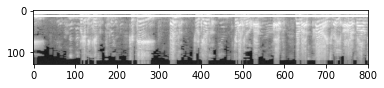

In [52]:
melspecgram = torchaudio.transforms.MelSpectrogram()(waveform)

print("Shape of spectrogram: {}".format(melspecgram.size()))

plt.figure()
p = plt.imshow(melspecgram.log2()[0,:,:].detach().numpy(), cmap='gray')

Shape of spectrogram: torch.Size([799, 201])


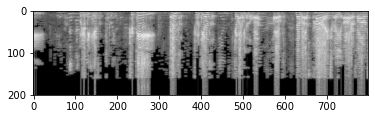

In [53]:
n_fft = 400.0
frame_length = n_fft / sample_rate * 1000.0
frame_shift = frame_length / 2.0

params = {
    "channel": 0,
    "dither": 0.0,
    "window_type": "hanning",
    "frame_length": frame_length,
    "frame_shift": frame_shift,
    "remove_dc_offset": False,
    "round_to_power_of_two": False,
    "sample_frequency": sample_rate,
}

kaldi_specgram = torchaudio.compliance.kaldi.spectrogram(waveform, **params)

print("Shape of spectrogram: {}".format(kaldi_specgram.size()))

plt.figure()
plt.imshow(kaldi_specgram.t().numpy(), cmap='gray')

Shape of fbank: torch.Size([799, 23])


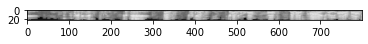

In [54]:
kaldi_fbank = torchaudio.compliance.kaldi.fbank(waveform, **params)

print("Shape of fbank: {}".format(kaldi_fbank.size()))

plt.figure()
plt.imshow(kaldi_fbank.t().numpy(), cmap='gray')

Shape of mfcc: torch.Size([799, 13])


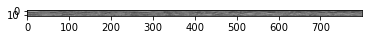

In [57]:
kaldi_mfcc = torchaudio.compliance.kaldi.mfcc(waveform, **params)

print("Shape of mfcc: {}".format(kaldi_mfcc.size()))

plt.figure()
plt.imshow(kaldi_mfcc.t().numpy(), cmap='gray')

In [56]:
def normalize(tensor):
    # Subtract the mean, and scale to the interval [-1,1]
    tensor_minusmean = tensor - tensor.mean()
    return tensor_minusmean/tensor_minusmean.abs().max()

# Let's normalize to the full interval [-1,1]
# waveform = normalize(waveform)




我们使用标签列表中的每个索引对每个标签进行编码。

In [55]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))

def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]

word_start = "积极高唤醒"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

ValueError: substring not found


为了将由录音和语音构成的数据点列表转换为该模型的两个成批张量，我们实现了整理函数，PyTorch `DataLoader`使用了该函数，允许我们分批迭代数据集。 有关使用整理函数的更多信息，请参见[文档](https://pytorch.org/docs/stable/data.html#working-with-collate-fn)。

在整理函数中，我们还应用了重采样和文本编码。

In [39]:

def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)

def collate_fn(batch):
    # A data tuple has the form:
    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]
    
    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)
    return tensors, targets

batch_size = 16

if device == "cuda":
    num_workers = 4
    pin_memory = True
    
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

## 定义网络

在本教程中，我们将使用卷积神经网络来处理原始音频数据。 通常，更高级的转换将应用于音频数据，但是 CNN 可以用于准确处理原始数据。 具体架构是根据[本文](https://arxiv.org/pdf/1610.00087.pdf)中描述的 M5 网络架构建模的。 模型处理原始音频数据的一个重要方面是其第一层过滤器的接收范围。 我们模型的第一个过滤器长度为 80，因此在处理以 8kHz 采样的音频时，接收场约为 10ms（而在 4kHz 时约为 20ms）。 此大小类似于语音处理应用，该应用通常使用 20ms 到 40ms 的接收域。


In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Parameter


class Res2Conv1dReluBn(nn.Module):
    def __init__(self, channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False, scale=4):
        super().__init__()
        assert channels % scale == 0, "{} % {} != 0".format(channels, scale)
        self.scale = scale
        self.width = channels // scale
        self.nums = scale if scale == 1 else scale - 1

        self.convs = []
        self.bns = []
        for i in range(self.nums):
            self.convs.append(nn.Conv1d(self.width, self.width, kernel_size, stride, padding, dilation, bias=bias))
            self.bns.append(nn.BatchNorm1d(self.width))
        self.convs = nn.ModuleList(self.convs)
        self.bns = nn.ModuleList(self.bns)

    def forward(self, x):
        out = []
        spx = torch.split(x, self.width, 1)
        for i in range(self.nums):
            if i == 0:
                sp = spx[i]
            else:
                sp = sp + spx[i]
            # Order: conv -> relu -> bn
            sp = self.convs[i](sp)
            sp = self.bns[i](F.relu(sp))
            out.append(sp)
        if self.scale != 1:
            out.append(spx[self.nums])
        out = torch.cat(out, dim=1)
        return out


class Conv1dReluBn(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False):
        super().__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding, dilation, bias=bias)
        self.bn = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        return self.bn(F.relu(self.conv(x)))


class SE_Connect(nn.Module):
    def __init__(self, channels, s=2):
        super().__init__()
        assert channels % s == 0, "{} % {} != 0".format(channels, s)
        self.linear1 = nn.Linear(channels, channels // s)
        self.linear2 = nn.Linear(channels // s, channels)

    def forward(self, x):
        out = x.mean(dim=2)
        out = F.relu(self.linear1(out))
        out = torch.sigmoid(self.linear2(out))
        out = x * out.unsqueeze(2)
        return out


def SE_Res2Block(channels, kernel_size, stride, padding, dilation, scale):
    return nn.Sequential(
        Conv1dReluBn(channels, channels, kernel_size=1, stride=1, padding=0),
        Res2Conv1dReluBn(channels, kernel_size, stride, padding, dilation, scale=scale),
        Conv1dReluBn(channels, channels, kernel_size=1, stride=1, padding=0),
        SE_Connect(channels)
    )


class AttentiveStatsPool(nn.Module):
    def __init__(self, in_dim, bottleneck_dim):
        super().__init__()
        # Use Conv1d with stride == 1 rather than Linear, then we don't need to transpose inputs.
        self.linear1 = nn.Conv1d(in_dim, bottleneck_dim, kernel_size=1)  # equals W and b in the paper
        self.linear2 = nn.Conv1d(bottleneck_dim, in_dim, kernel_size=1)  # equals V and k in the paper

    def forward(self, x):
        # DON'T use ReLU here! In experiments, I find ReLU hard to converge.
        alpha = torch.tanh(self.linear1(x))
        alpha = torch.softmax(self.linear2(alpha), dim=2)
        mean = torch.sum(alpha * x, dim=2)
        residuals = torch.sum(alpha * x ** 2, dim=2) - mean ** 2
        std = torch.sqrt(residuals.clamp(min=1e-9))
        return torch.cat([mean, std], dim=1)


class EcapaTdnn(nn.Module):
#     def __init__(self, n_input=1, n_output=4, stride=16, n_channel=32):
    def __init__(self, num_classes, input_size=80, channels=512, embd_dim=192):
        super().__init__()
        self.layer1 = Conv1dReluBn(input_size, channels, kernel_size=5, padding=2, dilation=1)
        self.layer2 = SE_Res2Block(channels, kernel_size=3, stride=1, padding=2, dilation=2, scale=8)
        self.layer3 = SE_Res2Block(channels, kernel_size=3, stride=1, padding=3, dilation=3, scale=8)
        self.layer4 = SE_Res2Block(channels, kernel_size=3, stride=1, padding=4, dilation=4, scale=8)

        cat_channels = channels * 3
        out_channels = cat_channels * 2
        self.conv = nn.Conv1d(cat_channels, cat_channels, kernel_size=1)
        self.pooling = AttentiveStatsPool(cat_channels, 128)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.linear = nn.Linear(out_channels, embd_dim)
        self.bn2 = nn.BatchNorm1d(embd_dim)
        self.fc = nn.Linear(embd_dim, num_classes)

    def forward(self, x):
        out1 = self.layer1(x)
        out2 = self.layer2(out1) + out1
        out3 = self.layer3(out1 + out2) + out1 + out2
        out4 = self.layer4(out1 + out2 + out3) + out1 + out2 + out3

        out = torch.cat([out2, out3, out4], dim=1)
        out = F.relu(self.conv(out))
        out = self.bn1(self.pooling(out))
        out = self.bn2(self.linear(out))
        return out




In [59]:
model = EcapaTdnn( num_classes=len(labels), input_size=transformed.shape[0])
print(model.layer1)
if torch.cuda.device_count() > 1:
    gpus = [0, 1, 2, 3]
    torch.cuda.set_device('cuda:{}'.format(gpus[0]))
    model = torch.nn.DataParallel(model.to(device), device_ids=gpus,output_device=gpus[0])
else:
    model.to(device)    

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

n = count_parameters(model)
print("Number of parameters: %s" % n)

Conv1dReluBn(
  (conv): Conv1d(1, 512, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
  (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Number of parameters: 5985285


我们将使用与本文相同的优化技术，将权重衰减设置为 0.0001 的 Adam 优化器。 首先，我们将以 0.01 的学习率进行训练，但是在 20 个周期后的训练过程中，我们将使用`scheduler`将其降低到 0.001。


In [42]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10



## 训练和测试网络

现在，我们定义一个训练函数，它将训练数据输入模型中，并执行反向传播和优化步骤。 对于训练，我们将使用的损失是负对数可能性。 然后，在每个周期之后将对网络进行测试，以查看训练期间准确率如何变化。


In [43]:
def train(model, epoch, log_interval):
    model.train()
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)
        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)
        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    #update progress bar
#     pbar.update(pbar_update)
    # print training stats
    if batch_idx % log_interval == 0:
        print(f"Train Epoch: {epoch}    [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]  Loss: {loss.item():.6f}   Accuracy: {correct}/{len(train_loader.dataset)} ({100. * correct / len(train_loader.dataset):.0f}%)")
        # record loss
        losses.append(loss.item())
        # record training Accuracy
    train_acc.append(correct / len(train_loader.dataset))

现在我们有了训练函数，我们需要制作一个用于测试网络准确率的函数。 我们将模型设置为`eval()`模式，然后对测试数据集进行推断。 调用`eval()`将网络中所有模块中的训练变量设置为`false`。 某些层（例如批量归一化层和丢弃层）在训练期间的行为会有所不同，因此此步骤对于获取正确的结果至关重要。


In [44]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()

def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)

In [45]:
def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)
        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)
        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

#     update progress bar
#     pbar.update(pbar_update)
#     print training stats
    print(f" Test Epoch: {epoch}  Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%) ")
    # test acc
    test_acc.append(correct / len(test_loader.dataset))
    # 保存模型
#     torch.save(model,'model_{}.pth'.format(epoch+1))
#     print("第{}轮模型训练数据已保存".format(epoch+1))

In [46]:
def val(model, epoch):
    model.eval()
    correct = 0
    
    for data, target in val_loader:
        data = data.to(device)
        target = target.to(device)
        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)
        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

#     update progress bar
#     pbar.update(pbar_update)
    # print training stats
    print(f" val Epoch: {epoch}  Accuracy: {correct}/{len(val_loader.dataset)} ({100. * correct / len(val_loader.dataset):.0f}%) ")
    # test acc
    val_acc.append(correct / len(val_loader.dataset))
    # 保存模型
    torch.save(model,'output/checkpoints/model_{}.pth'.format(val_acc))
#     print("第{}轮模型训练数据已保存".format(epoch+1))

最后，我们可以训练和测试网络。 我们将训练网络十个周期，然后降低学习率，再训练十个周期。 在每个周期之后将对网络进行测试，以查看训练过程中准确率如何变化。


In [47]:
log_interval = 1
n_epoch = 50


print('Start Training...')
from datetime import datetime
nowtime = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print('========='*8 + '%s'%nowtime)

pbar_update = 1 
losses = []
test_acc=[]
train_acc=[]
val_acc=[]
# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        test(model, epoch)
#         val(model,epoch)
        scheduler.step()
        pbar.update(pbar_update)    
dfhistory=pd.DataFrame(data=[losses,test_acc,train_acc,val_acc],index = ['losses','test_acc','train_acc','val_acc']).T  
# 保存训练日志
dfhistory.to_csv(f'output/train_test_history.csv')

Start Training...
========================================================================2022-06-04 21:08:05


RuntimeError: Caught RuntimeError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/torch/nn/parallel/parallel_apply.py", line 61, in _worker
    output = module(*input, **kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1110, in _call_impl
    return forward_call(*input, **kwargs)
  File "<ipython-input-40-b64f86ca3879>", line 113, in forward
    out3 = self.layer3(out1 + out2) + out1 + out2
RuntimeError: CUDA out of memory. Tried to allocate 626.00 MiB (GPU 0; 11.91 GiB total capacity; 11.18 GiB already allocated; 36.31 MiB free; 11.23 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


Text(0.5, 1.0, 'training loss')

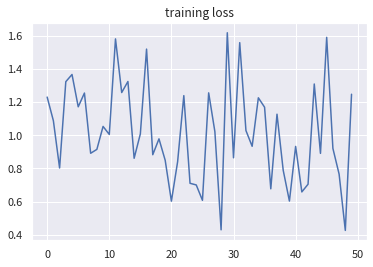

In [ ]:
# Let's plot the training loss versus the number of iteration.
plt.plot(losses)
plt.title("training loss")

Text(0.5, 1.0, 'Accuracy')

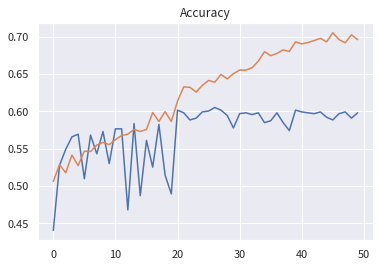

In [ ]:
plt.plot(test_acc,label='test')
plt.plot(train_acc,label='train')
plt.plot(val_acc,label='val')
plt.title("Accuracy")


让我们看一下训练集中的最后几个数据

In [ ]:
def predict(tensor):
    # Use the model to predict the label of the waveform
    tensor = tensor.to(device)
    tensor = transform(tensor)
    tensor = model(tensor.unsqueeze(0))
    tensor = get_likely_index(tensor)
    tensor = index_to_label(tensor.squeeze())
    return tensor

waveform, sample_rate, label, P, A, sex, speaker_id, utterance_number= train_set[-1]
ipd.Audio(waveform.numpy(), rate=sample_rate)

print(f"Expected: {label}. Predicted: {predict(waveform)}.")


Expected: 积极高唤醒. Predicted: 积极高唤醒.


如果有一个示例，我们来寻找一个分类错误的示例。

In [ ]:
for i, (waveform, sample_rate, label, *_) in enumerate(test_set):
    output = predict(waveform)
    if output != label:
        ipd.Audio(waveform.numpy(), rate=sample_rate)
        print(f"Data point #{i}. Expected: {label}. Predicted: {output}.")
        break
else:
    print("All examples in this dataset were correctly classified!")
    print("In this case, let's just look at the last data point")
    ipd.Audio(waveform.numpy(), rate=sample_rate)
    print(f"Data point #{i}. Expected: {label}. Predicted: {output}.")

Data point #5. Expected: 积极低唤醒. Predicted: 消极高唤醒.


### 绘制混淆矩阵

In [ ]:

y_true=[]
y_pred=[]
for i, (waveform, sample_rate, label, *_) in enumerate(test_set):
    output = predict(waveform)
    if output != label:
        ipd.Audio(waveform.numpy(), rate=sample_rate)
#         print(f"Data point #{i}. Expected: {label}. Predicted: {output}.")
        y_pred.append(output)
        y_true.append(label)
if len(y_pred)==0:
    print("All examples in this dataset were correctly classified!")
    print("In this case, let's just look at the last data point")
    ipd.Audio(waveform.numpy(), rate=sample_rate)
    print(f"Data point #{i}. Expected: {label}. Predicted: {output}.")


       消极低唤醒  消极高唤醒  积极低唤醒  积极高唤醒
消极低唤醒      0     34      1     92
消极高唤醒     19      0      0     30
积极低唤醒      7     49      0      8
积极高唤醒     42     55      0      0


Text(29.90625, 0.5, 'true')

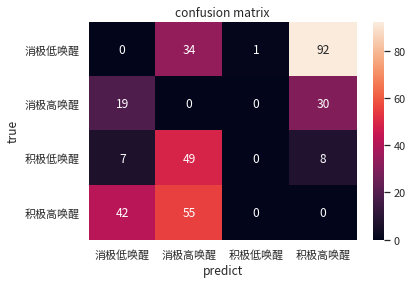

In [ ]:
from sklearn.metrics import confusion_matrix
from matplotlib.font_manager import FontProperties
myfont=FontProperties(fname=r'/usr/share/fonts/opentype/noto/NotoSansCJK-Bold.ttc',size=14)
rc = {'axes.unicode_minus': False}
sns.set(context='notebook', style='ticks',font=myfont.get_family() , rc=rc)
sns.set_style("darkgrid",{"font.sans-serif":['Noto Sans CJK JP']})
C=confusion_matrix(y_true, y_pred, labels=labels)
df=pd.DataFrame(C,index=labels,columns=labels)
f,ax=plt.subplots()
print(df) #打印出来看看
sns.heatmap(df,annot=True,ax=ax) #画热力图
ax.set_title('confusion matrix') #标题
ax.set_xlabel('predict') #x轴
ax.set_ylabel('true') #y轴

## 总结

在本教程中，我们使用了`torchaudio`来加载数据集并对信号进行重新采样。 然后，我们定义了经过训练的神经网络，以识别给定命令。 还有其他数据预处理方法，例如找到梅尔频率倒谱系数（MFCC），可以减小数据集的大小。 此变换也可以在`torchaudio`中作为`torchaudio.transforms.MFCC`使用。


In [ ]:
print(waveform.numpy().shape)

(1, 160000)
